<div style="font-family: system-ui, -apple-system, BlinkMacSystemFont, 'Segoe UI', sans-serif; border: 1px solid #ddd; border-radius: 10px; padding: 16px 20px; margin-bottom: 16px; background: #fafafa;">
  <h1 style="margin-top: 0; margin-bottom: 8px; font-size: 24px;">HAVI – Analiza struktury popytu: kraje i portfel produktów</h1>
  <p style="margin: 0; font-size: 14px;">
    Celem analizy jest syntetyczne opisanie struktury popytu w ujęciu krajowym i produktowym,
    ze szczególnym uwzględnieniem skali rynków, koncentracji wolumenu oraz implikacji
    dla dalszego modelowania i raportowania.
  </p>
</div>

Analiza bazuje na zbiorze <code>master_model_ready</code> i koncentruje się wyłącznie
na informacjach istotnych z punktu widzenia decyzji analitycznych i biznesowych.
Eksploracja jakości danych, sezonowości oraz dynamiki czasowej została wykonana
we wcześniejszych etapach.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from pathlib import Path

pd.set_option("display.max_rows", 25)
pd.set_option("display.max_columns", None)

DATA_DIR = Path("data")
df = pd.read_parquet(DATA_DIR / "master_model_ready.parquet")


### Skala rynków – wolumen popytu per kraj

Pierwszym krokiem analizy jest porównanie całkowitego wolumenu popytu pomiędzy krajami,
co pozwala określić relatywną wagę poszczególnych rynków oraz ich znaczenie
w strukturze całego portfela.


In [4]:
country_summary = (
    df.groupby("country", observed=False, as_index=False)["demand_raw"]
      .sum()
      .rename(columns={"demand_raw": "total_demand"})
)

country_summary["share_%"] = (
    country_summary["total_demand"]
    / country_summary["total_demand"].sum()
    * 100
).round(2)

country_summary = country_summary.sort_values("total_demand", ascending=False)
country_summary


,country,total_demand,share_%
1,Poland,3296204.300,26.02
0,Germany,3120581.000,24.63
2,Portugal,2342683.661,18.49
5,Sweden,2254089.749,17.79
4,Spain,1178727.021,9.30
3,Romania,475445.357,3.75


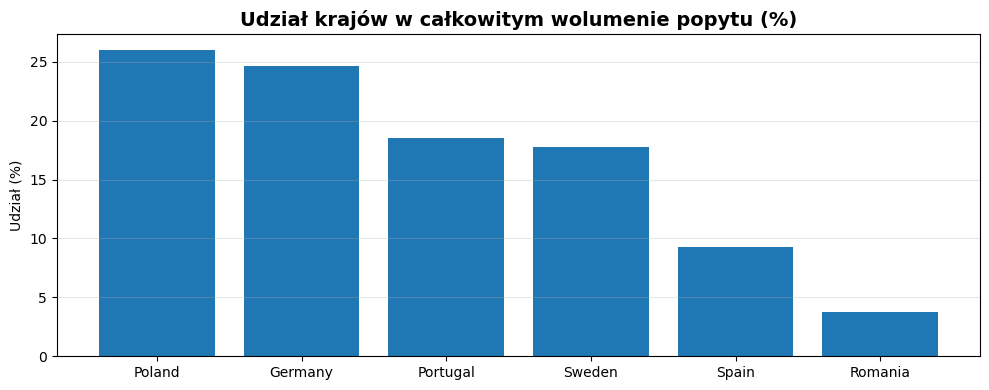

In [5]:
plt.figure(figsize=(10, 4))

plt.bar(
    country_summary["country"],
    country_summary["share_%"]
)

plt.title(
    "Udział krajów w całkowitym wolumenie popytu (%)",
    fontsize=14,
    fontweight="bold"
)
plt.ylabel("Udział (%)")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


Uzyskany rozkład wskazuje na wyraźną koncentrację wolumenu w ograniczonej liczbie rynków.
Różnice skali pomiędzy krajami są istotne i powinny być uwzględniane zarówno
w interpretacji wyników, jak i w dalszych etapach modelowania prognostycznego.


### Struktura dystrybucji – wolumen per centrum logistyczne (DC)

Uzupełnieniem analizy krajowej jest spojrzenie na rozkład wolumenu
pomiędzy centra dystrybucyjne, co pozwala zidentyfikować potencjalne
punkty koncentracji operacyjnej.


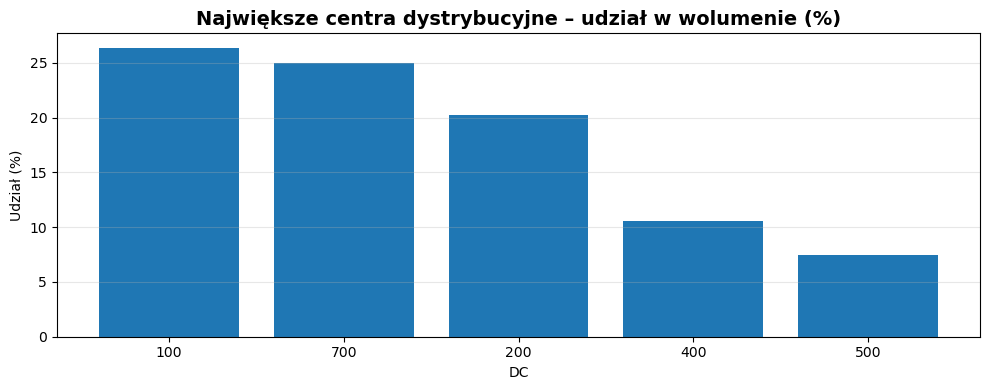

In [9]:
top_dc = dc_summary.head()

plt.figure(figsize=(10, 4))
plt.bar(top_dc["dc_id"].astype(str), top_dc["share_%"])

plt.title(
    "Największe centra dystrybucyjne – udział w wolumenie (%)",
    fontsize=14,
    fontweight="bold"
)
plt.ylabel("Udział (%)")
plt.xlabel("DC")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


Już na tym poziomie widoczna jest asymetria obciążenia sieci dystrybucyjnej,
co ma bezpośrednie znaczenie dla interpretacji agregatów krajowych
oraz dalszych analiz na poziomie produktów.


### Struktura popytu produktowego w krajach

Po zdefiniowaniu skali rynków, kolejnym krokiem jest ocena,
jak popyt rozkłada się pomiędzy produkty w ramach poszczególnych krajów.

Analiza koncentruje się wyłącznie na aktywnym portfelu sprzedażowym,
tj. produktach generujących rzeczywisty wolumen w danym kraju.


### Skala portfela produktowego

Liczba aktywnych produktów różni się pomiędzy krajami,
co bezpośrednio wpływa na poziom koncentracji popytu
oraz złożoność dalszego modelowania.


### Koncentracja popytu – dominujące produkty

Dla każdego kraju identyfikujemy produkty o największym znaczeniu wolumenowym.
Zamiast list Top-N, stosowana jest metryka udziału pojedynczego produktu
w całkowitym popycie kraju.


### Produkty o najwyższym udziale w popycie

Poniższa tabela prezentuje produkty o najwyższym udziale w wolumenie
w ramach każdego kraju. Jest to syntetyczny obraz koncentracji portfela,
bez nadmiarowych szczegółów.


In [12]:
top_products = (
    sku_country
    .sort_values(["country", "share_%"], ascending=[True, False])
    .groupby("country", observed=False, as_index=False)
    .head(5)
    .loc[:, ["country", "product_name", "total_demand", "share_%"]]
)

(top_products
 .style
 .format({
     "total_demand": "{:,.0f}",
     "share_%": "{:.2f}"
 })
 .background_gradient(subset=["share_%"], cmap="Oranges")
)


KeyError: 'share_%'

W każdym kraju obserwowany jest wyraźny efekt dominacji pojedynczych produktów,
które odpowiadają za znaczną część wolumenu popytu.
Zjawisko to ma istotne implikacje dla stabilności prognoz
oraz priorytetyzacji prac analitycznych.


In [ ]:
def prepare_top_products_for_year(df: pd.DataFrame, year: int, top_n: int = 5) -> pd.DataFrame:
    if "year" not in df.columns:
        df = df.copy()
        df["year"] = df["date"].dt.year

    agg = (
        df.groupby(["country", "year", "product_name"], observed=False)["demand_raw"]
          .sum()
          .reset_index()
          .rename(columns={"demand_raw": "total_demand"})
    )

    agg = agg[(agg["total_demand"] > 0) & (agg["year"] == year)].copy()

    if agg.empty:
        return agg

    top = (
        agg.sort_values(["country", "total_demand"], ascending=[True, False])
           .groupby("country", observed=False, as_index=False)
           .head(top_n)
           .copy()
    )

    country_order = (
        top.groupby("country", observed=False)["total_demand"]
           .sum()
           .sort_values(ascending=False)
           .index
           .tolist()
    )
    top["country"] = pd.Categorical(top["country"], categories=country_order, ordered=True)

    top = top.sort_values(["country", "total_demand"], ascending=[True, False]).reset_index(drop=True)

    return top

In [ ]:
def plot_top_products_year(
    top_df: pd.DataFrame,
    year: int,
    title_prefix: str = "Top produkty – wolumen popytu",
    bar_width: float = 0.55,
):
    if top_df.empty:
        print(f"Brak danych dla roku {year}.")
        return

    x = np.arange(len(top_df))
    y = top_df["total_demand"].values
    labels = top_df["product_name"].astype(str).values

    fig, ax = plt.subplots(figsize=(16, 6))

    ax.bar(x, y, width=bar_width)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{v:,.0f}"))

    ax.grid(axis="y", alpha=0.25)
    ax.set_axisbelow(True)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=35, ha="right")

    ax.set_ylabel("Wolumen / popyt (suma w roku)")
    ax.set_title(f"{title_prefix} ({year})", fontsize=14, fontweight="bold")

    countries = top_df["country"].astype(str).values
    boundaries = []
    start = 0
    for i in range(1, len(countries) + 1):
        if i == len(countries) or countries[i] != countries[i-1]:
            end = i - 1
            boundaries.append((countries[i-1], start, end))
            start = i

    for j, (c, s, e) in enumerate(boundaries):
        if j % 2 == 0:
            ax.axvspan(s - 0.5, e + 0.5, alpha=0.06)  

        mid = (s + e) / 2
        ax.text(
            mid, -0.22, c,
            ha="center", va="top",
            transform=ax.get_xaxis_transform(),  
            fontsize=11, fontweight="bold"
        )

        ax.axvline(e + 0.5, linewidth=0.8, alpha=0.25)

    plt.subplots_adjust(bottom=0.28)
    plt.tight_layout()
    plt.show()


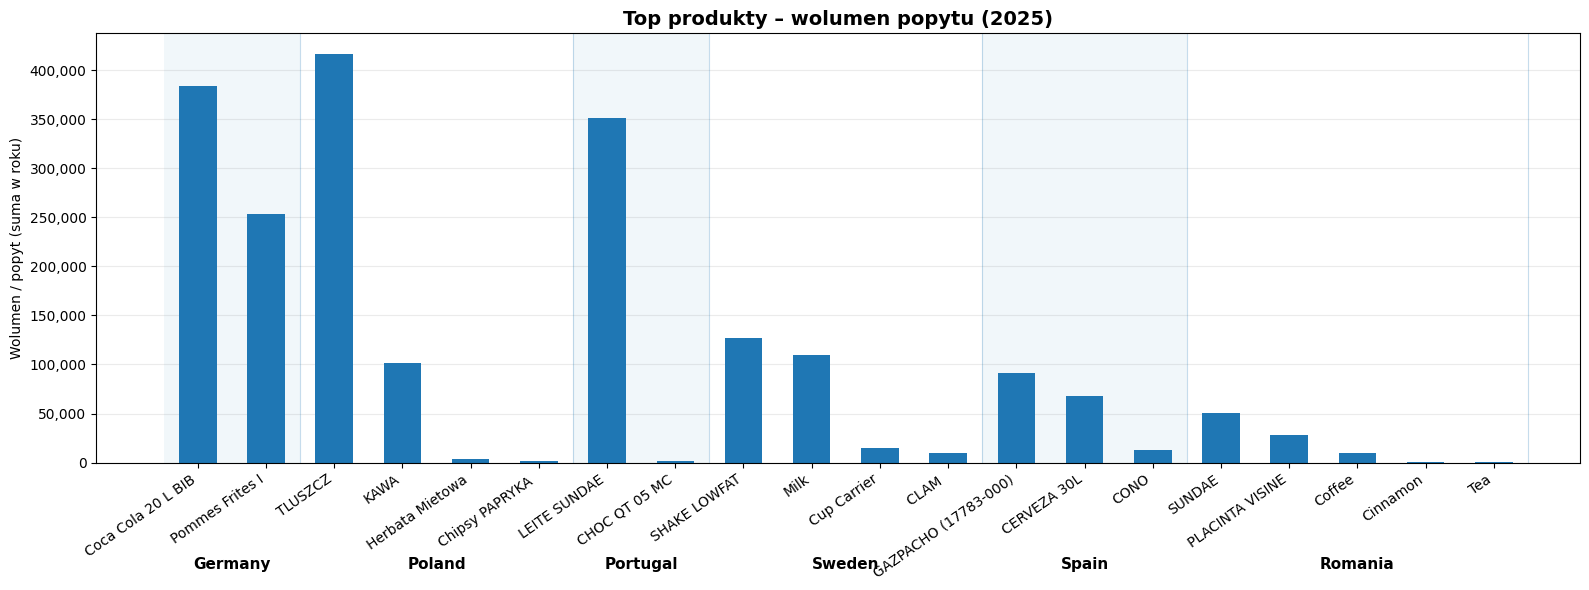

In [ ]:
YEAR = 2025
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


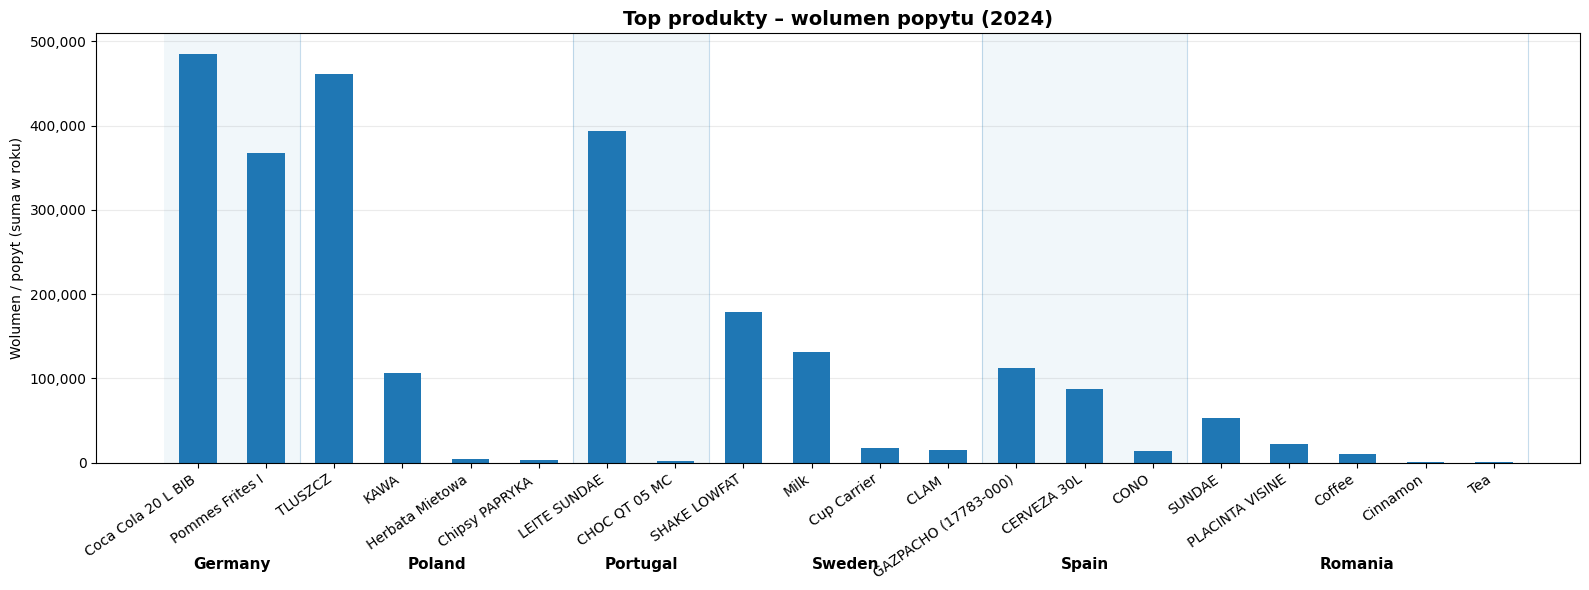

In [ ]:
YEAR = 2024
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


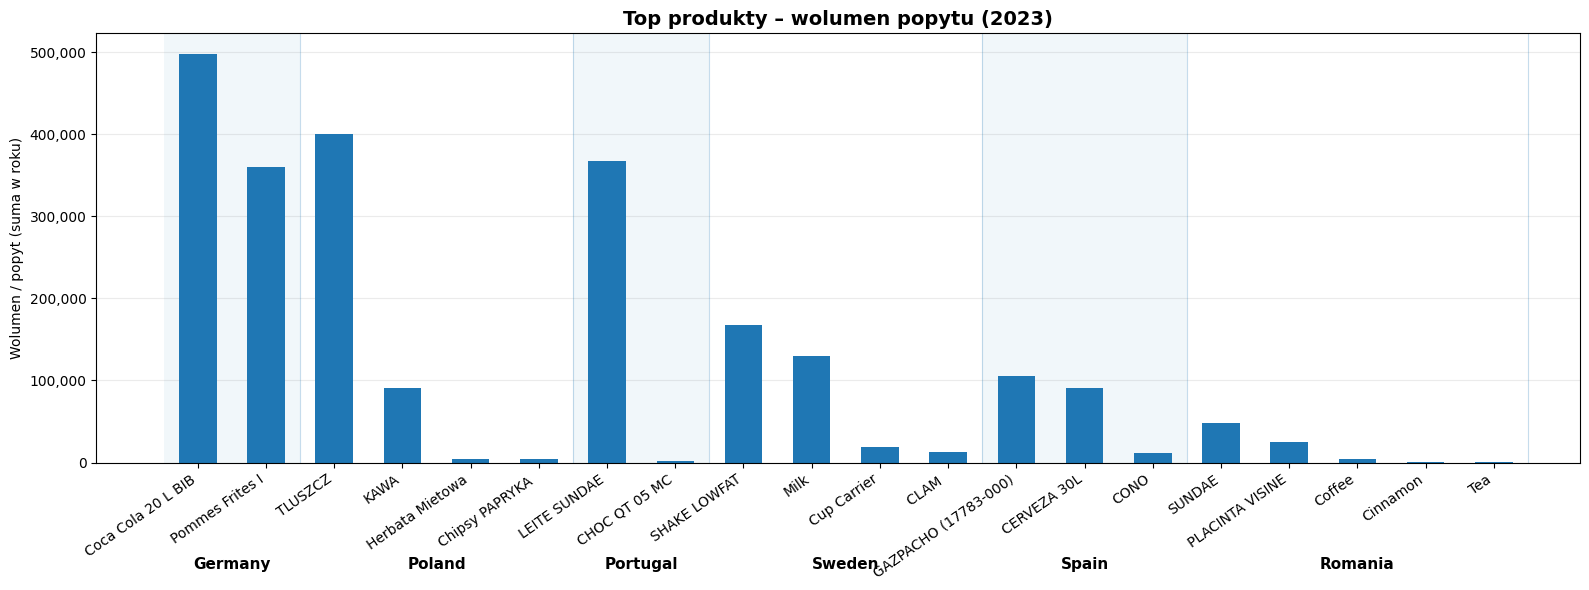

In [ ]:
YEAR = 2023
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


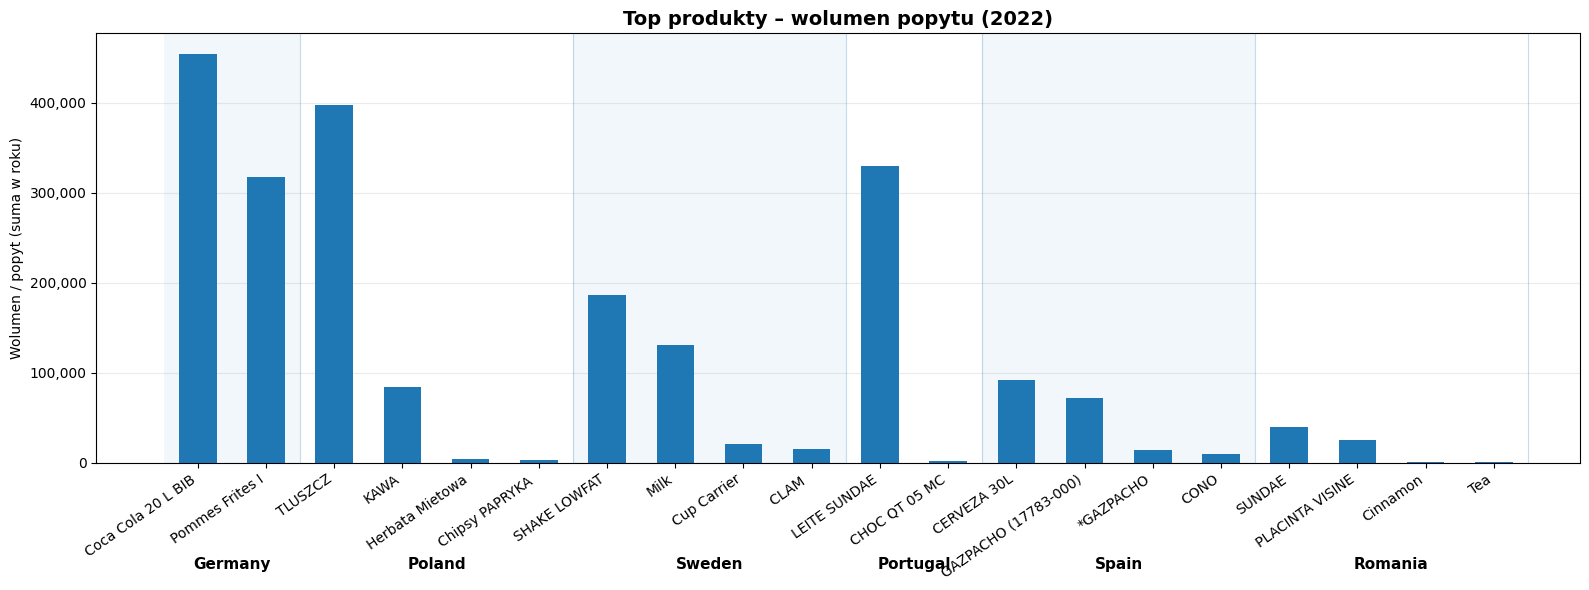

In [ ]:
YEAR = 2022
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


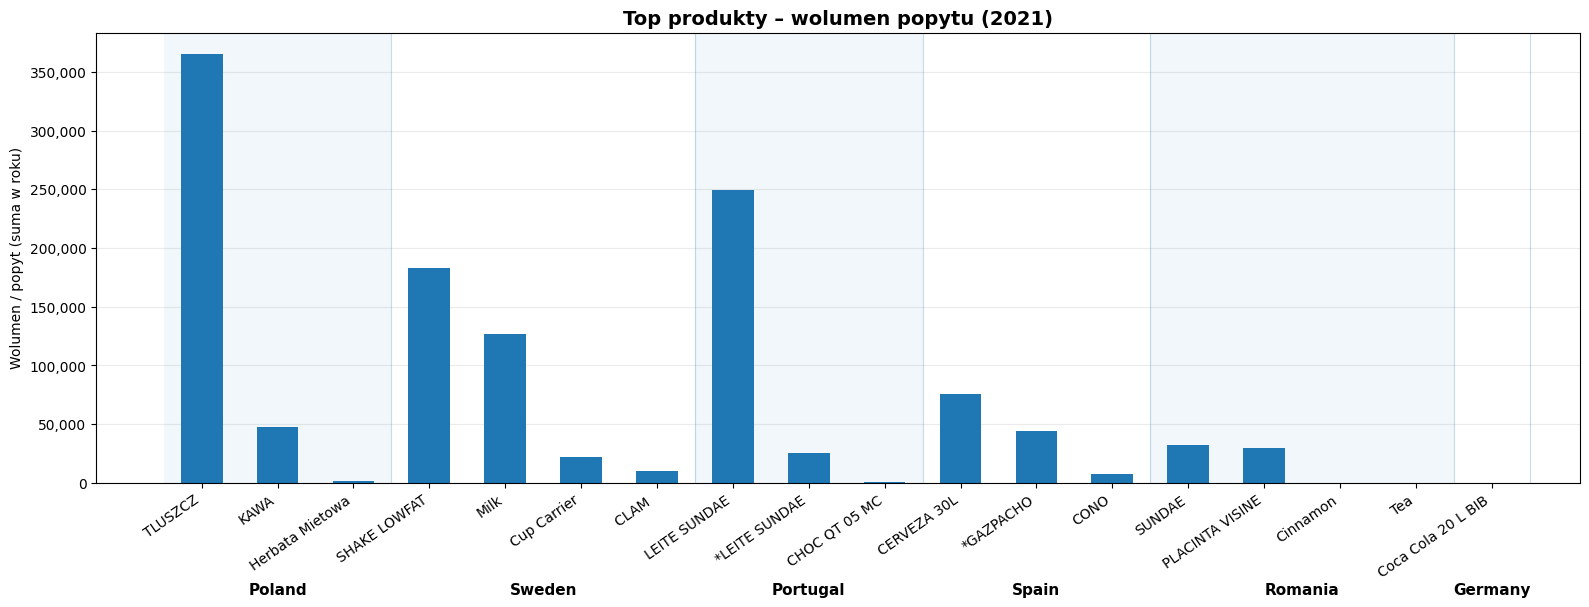

In [ ]:
YEAR = 2021
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


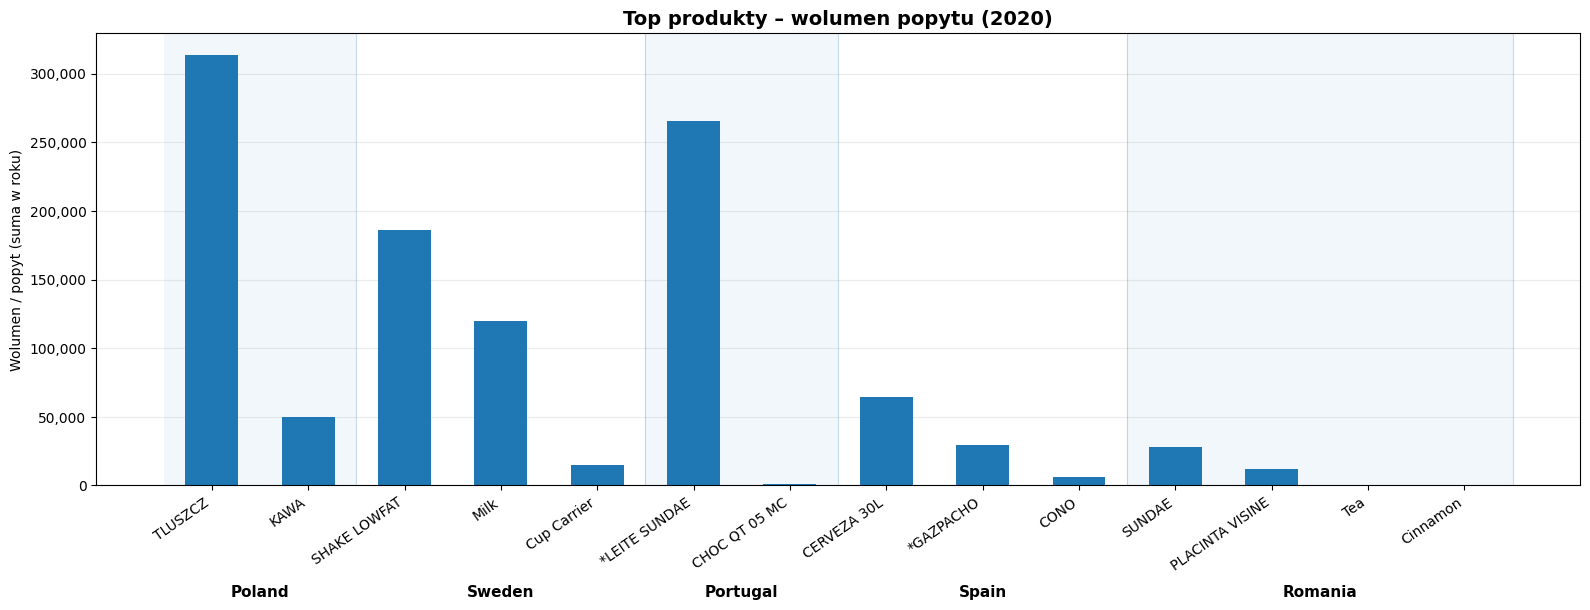

In [ ]:
YEAR = 2020
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


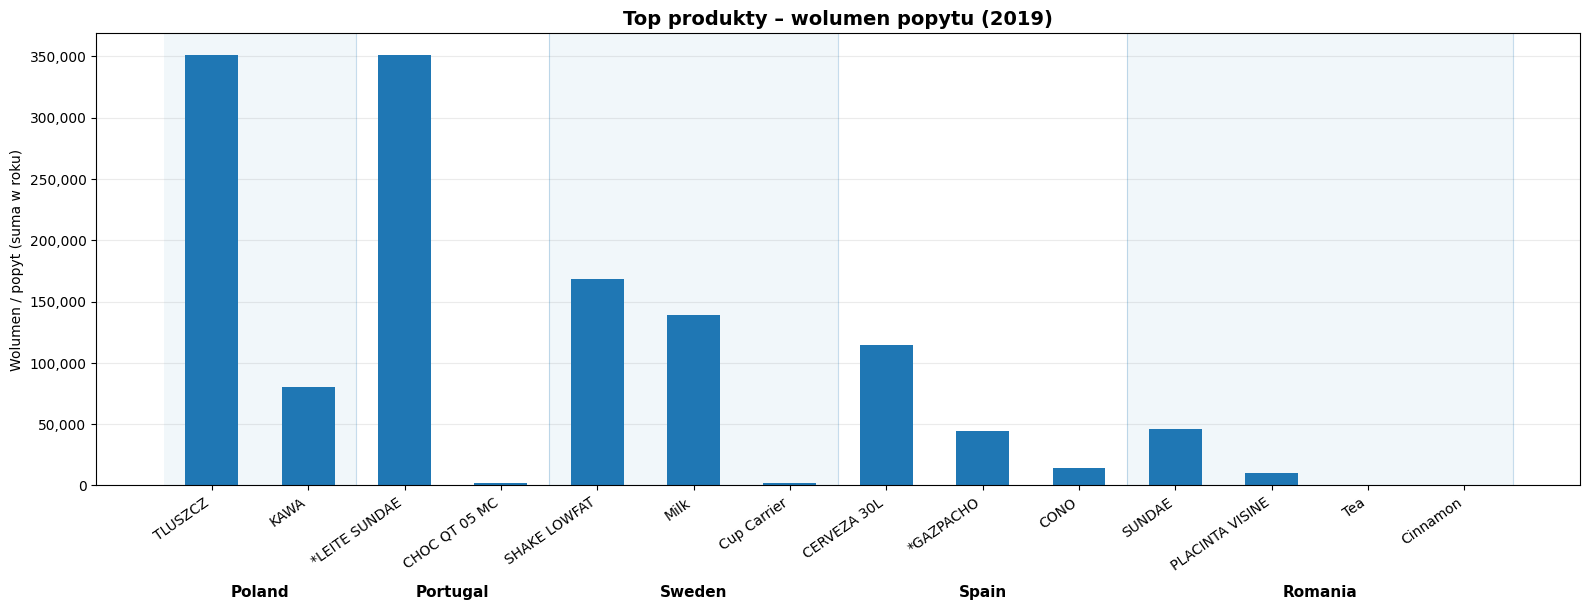

In [ ]:
YEAR = 2019
top_year = prepare_top_products_for_year(df, year=YEAR, top_n=5)
plot_top_products_year(top_year, year=YEAR)


### Zróżnicowanie portfela – miara koncentracji

Dla formalnego porównania struktury portfela pomiędzy krajami
zastosowano wskaźnik koncentracji Herfindahla-Hirschmana (HHI),
liczony na bazie udziałów wolumenu produktów.


In [ ]:
def hhi(series: pd.Series) -> float:
    return np.sum((series / series.sum()) ** 2)

hhi_country = (
    sku_country
    .groupby("country", observed=False)["total_demand"]
    .apply(hhi)
    .round(3)
    .rename("HHI")
    .reset_index()
)

hhi_country


,country,HHI
0,Germany,0.514
1,Poland,0.703
2,Portugal,0.596
3,Romania,0.497
4,Spain,0.373
5,Sweden,0.439


Wyższe wartości HHI wskazują na silniejszą koncentrację popytu
na ograniczonej liczbie produktów, natomiast niższe
na bardziej zdywersyfikowany portfel.


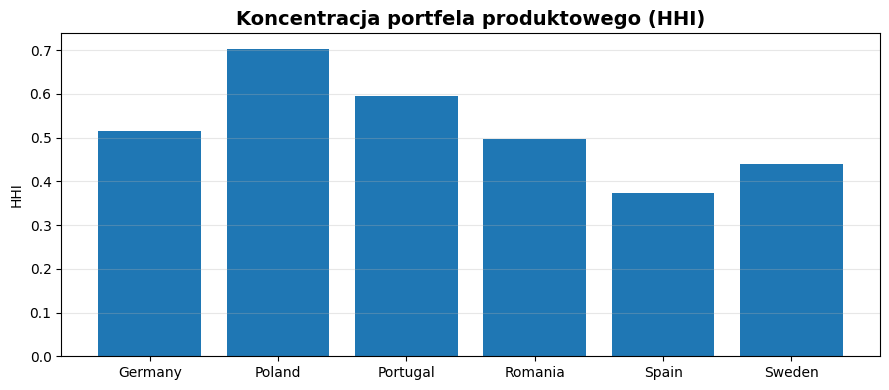

In [ ]:
plt.figure(figsize=(9, 4))

plt.bar(hhi_country["country"], hhi_country["HHI"])
plt.title(
    "Koncentracja portfela produktowego (HHI)",
    fontsize=14,
    fontweight="bold"
)
plt.ylabel("HHI")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


Zróżnicowanie poziomu koncentracji pomiędzy krajami sugeruje,
że portfel produktowy nie jest jednorodny strukturalnie,
co należy uwzględnić w dalszych analizach porównawczych
oraz w projektowaniu podejścia prognostycznego.


Analiza struktury portfela produktowego zostaje uzupełniona
o perspektywę operacyjną – poziom centrów dystrybucyjnych (DC).

Pozwala to ocenić:
- stopień centralizacji popytu w krajach,
- złożoność operacyjną portfela,
- potencjalne źródła niestabilności danych.


In [ ]:
dc_country = (
    df.groupby(["country", "dc_id"], observed=False, as_index=False)["demand_raw"]
      .sum()
      .rename(columns={"demand_raw": "total_demand"})
)

dc_country = dc_country[dc_country["total_demand"] > 0]
dc_country.head()


,country,dc_id,total_demand
0,Germany,100,349662.0
2,Germany,200,302691.0
3,Germany,300,305711.0
4,Germany,400,198358.0
5,Germany,500,132432.0


### Skala operacyjna krajów

Liczba aktywnych DC w kraju jest jednym z kluczowych czynników
wpływających na złożoność portfela i stabilność obserwacji.


In [ ]:
dc_summary = (
    dc_country.groupby("country", observed=False)["dc_id"]
      .nunique()
      .rename("active_dc")
      .reset_index()
)

dc_summary


,country,active_dc
0,Germany,8
1,Poland,4
2,Portugal,4
3,Romania,3
4,Spain,7
5,Sweden,4


### Koncentracja wolumenu na poziomie DC

Analogicznie do produktów, oceniamy jak duża część popytu
skupiona jest w jednym dominującym centrum dystrybucyjnym.


In [ ]:
dc_country = dc_country.merge(
    dc_country.groupby("country")["total_demand"]
      .sum()
      .rename("country_total")
      .reset_index(),
    on="country",
    how="left"
)

dc_country["share_%"] = (
    dc_country["total_demand"]
    / dc_country["country_total"]
    * 100
).round(2)

dc_country.head()


C:\Users\48573\AppData\Local\Temp\ipykernel_11556\4205774366.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dc_country.groupby("country")["total_demand"]


,country,dc_id,total_demand,country_total_x,share_%,country_total_y,country_total
0,Germany,100,349662.0,3120581.0,11.21,3120581.0,3120581.0
1,Germany,200,302691.0,3120581.0,9.70,3120581.0,3120581.0
2,Germany,300,305711.0,3120581.0,9.80,3120581.0,3120581.0
3,Germany,400,198358.0,3120581.0,6.36,3120581.0,3120581.0
4,Germany,500,132432.0,3120581.0,4.24,3120581.0,3120581.0


### Dominujące DC w krajach

Poniżej przedstawiono centra dystrybucyjne
o największym udziale wolumenu w danym kraju.


In [ ]:
top_dc = (
    dc_country
    .sort_values(["country", "share_%"], ascending=[True, False])
    .groupby("country", observed=False, as_index=False)
    .head(1)
    .loc[:, ["country", "dc_id", "total_demand", "share_%"]]
)

(top_dc
 .style
 .format({
     "total_demand": "{:,.0f}",
     "share_%": "{:.2f}"
 })
 .background_gradient(subset=["share_%"], cmap="Blues")
)


,country,dc_id,total_demand,share_%
6,Germany,700,"1,415,255",45.35
8,Poland,100,"1,168,608",35.45
15,Portugal,700,"1,553,696",66.32
17,Romania,200,"248,422",52.25
19,Spain,100,"414,036",35.13
26,Sweden,100,"1,275,161",56.57


Widoczna jest istotna heterogeniczność struktur operacyjnych:
w części krajów popyt koncentruje się w jednym dominującym DC,
podczas gdy w innych rozkład jest bardziej równomierny.

Ma to bezpośrednie przełożenie na:
- ryzyko punktów krytycznych,
- interpretację anomalii popytu,
- konstrukcję walidacji czasowo-przestrzennej.


Ostatnim elementem oceny jakości portfela
jest długość i ciągłość obserwacji w czasie.

Różnice w dostępnej historii wpływają
na porównywalność modeli oraz stabilność estymacji.


In [ ]:
weeks_country = (
    df.groupby("country", observed=False)["date"]
      .nunique()
      .rename("n_weeks")
      .reset_index()
      .sort_values("n_weeks", ascending=False)
)

weeks_country


,country,n_weeks
2,Portugal,358
1,Poland,357
5,Sweden,356
3,Romania,356
4,Spain,352
0,Germany,202
